# Testing the IR AGN Selection from WISE
##### Authors: S. Juneau, M. Mezcua, B. Canning


### 1) First let's import some stuff!

In [1]:
# Numpy
import numpy as np
# Plotting stuff and suppressing boring warnings
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')

# Get the GQP code
import sys
# Set the path where the py scripts are
sys.path.append("../py/")
import set_agn_masksDESI

# Below: delete if not needed (TO DO)
#import yaml
#import pandas as pd
#import os.path
#import fitsio

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table #, join, Column
from astropy.io import fits

# DESI modules
#from desispec.zcatalog import find_primary_spectra, create_summary_catalog  # at NERSC needs DESI master
#from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask      # For the main survey
#from desiutil.bitmask import BitMask

#https://www.legacysurvey.org/viewer?ra=10.1572&dec=-0.3316&layer=ls-dr9&zoom=16

settings = {
    'font.size':16,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True,
    'axes.labelsize':16
}

plt.rcParams.update(**settings)

### 2) Now we are ready to open the catalog.

The internal GQP drive at NERSC is

        /global/cfs/cdirs/desi/science/gqp/

From there we can find the 'agncatalog' folder and follow the link on to 'catalog'

In [2]:
def return_catdir(location='nersc'):

    dl_path = '~/data/DESI/science/gqp/agncatalog/catalog/'
    nersc_path = '/global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/'

    if location=='datalab':
        return(dl_path)
    else:
        return(nersc_path)  #default

In [3]:
catdir = return_catdir(location='datalab')

# Open the catalog
agn_hdul = fits.open(f'{catdir}agnqso_sum_v1.3.fits', format='fits')
agn_hdul.info()

Filename: /home/jail/./dlusers/sjuneau_user/data/DESI/science/gqp/agncatalog/catalog/agnqso_sum_v1.3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    332   2254019R x 149C   [K, D, D, K, 6A, J, D, D, 4A, E, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, 7A, 6A, J, E, J, L, K, L, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, 1A, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, K]   


As we can see the data is stored in extension number 1.

In [4]:
# Load this into an astropy table
T = Table(agn_hdul[1].data)

Let's print the columns in this catalog.

In [5]:
# What are the columns?
T.columns

<TableColumns names=('TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV_1','MASKBITS','COADD_NUMEXP','COADD_EXPTIME','TSNR2_LYA','TSNR2_QSO','DELTA_CHI2_MGII','A_MGII','SIGMA_MGII','B_MGII','VAR_A_MGII','VAR_SIGMA_MGII','VAR_B_MGII','Z_RR','Z_QN','C_LYA','C_CIV','C_CIII','C_MgII','C_Hbeta','C_Halpha','Z_LYA','Z_CIV','Z_CIII','Z_MgII','Z_Hbeta','Z_Halpha','QSO_MASKBITS','SURVEY','PROGRAM','HEALPIX','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY','NPIXELS','DESI_TARGET','BGS_TARGET','SCND_TARGET','CMX_TARGET','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_SCND_TARGET','SV2_DESI_TARGET','SV2_BGS_TARGET','SV2_SCND_TARGET','SV3_DESI_TARGET','SV3_BGS_TARGET','SV3_SCND_TARGET','QN_C_LINE_BEST','QN_C_LINE_SECOND_BEST','PHOTSYS','LS_ID','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_W3','FLUX_W4','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z'

In particular we acess information about the AGN and QSO diagnostics via the AGN_MASKBITS and AGN_TYPE columns. We can read the definitions for the bitmasks in the yaml file.

In [6]:
QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = set_agn_masksDESI.get_qso_maskbits('../py/agnmask.yaml')

These are the bitmask which contain the infomation. The format of these bitmasks is:    

    - [name of the target bit,  bit value,  "description as a string"]
    
For example:

    - [NII_SY,           8, "NII BPT Seyfert"]
    
This means the name of the target bit is NII_SY, its bit value is 2$^{8}$ and its description is a Seyfert object according to the NII BPT.

So let's see what the bitmasks look like.

In [7]:
print(QSO_MASKBITS)

QSO_MASKBITS:
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]


In [8]:
print(AGN_MASKBITS)

AGN_MASKBITS:
  - [AGN_ANY,          0, "any agn classification is set"]
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]
  - [BPT_ANY_AGN,      5, "At least one BPT diagnostic indicates SEYFERT, LINER or COMPOSITE"]
  - [OPT_OTHER_AGN,    6, "Rest frame optical emission lines diagnostic not bpt (4000-10000 ang) indicate agn"]
  - [UV,               7, "Rest frame UV emission lines indicate agn"]
  - [WISE,             8, "Infrared (WISE) colours indicate agn"]
  - [XRAY,             9, "X-rays indicate agn"]
  - [RADIO,           10, "Radio indicates agn"]


In [9]:
print(AGN_TYPE)

AGN_TYPE:
  - [UNKNOWN,          0, "Unknown agn type"]
  - [TYPE1,            1, "Type 1 agn (FWHM>1500 km/s or >1000 km/s in a Balmer line)"]
  - [TYPE2,            2, "Type 2 agn (FWHM<1500 km/s or <1000 km/s in a Balmer line)"]
  - [BPT_SY,           3, "Any BPT diagnostic indicates Seyfert"]
  - [BPT_LINER,        4, "Any BPT diagnostic indicates LINER"]
  - [NII_BPT_AV,       5, "NII BPT diagnostic is avalible"]
  - [NII_SF,           6, "NII BPT Star-forming"]
  - [NII_COMP,         7, "NII BPT Composite"]
  - [NII_SY,           8, "NII BPT Seyfert"]
  - [NII_LINER,        9, "NII BPT LINER"]
  - [NII_QUIES,       10, "NII BPT Quiescent, Lines detected with (S/N) < 3"]
  - [SII_BPT_AV,      11, "SII BPT diagnostic is available"]
  - [SII_SF,          12, "SII BPT Star-forming"]
  - [SII_SY,          13, "SII BPT Seyfert"]
  - [SII_LINER,       14, "SII BPT LINER"]
  - [SII_QUIES,       15, "SII BPT Quiescent, Lines detected with (S/N) < 3"]
  - [OI_BPT_AV,       16, "OI BPT dian

### 3) IR diagnostic diagram: WISE Color-Color

In [10]:
is_wise = (T['AGN_TYPE'] & AGN_TYPE.WISE_AGN != 0)

In [11]:
w1w2 = -2.5*np.log10(T['FLUX_W1']/T['FLUX_W2'])
w2w3 = -2.5*np.log10(T['FLUX_W2']/T['FLUX_W3'])

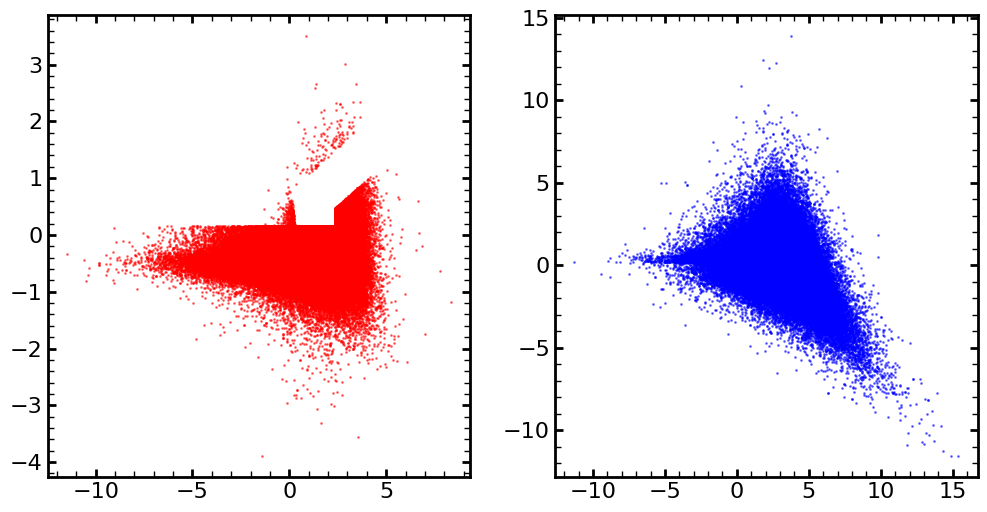

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.scatter(w2w3[is_wise], w1w2[is_wise], color='r', s=1, alpha=0.5)
ax2.scatter(w2w3[~is_wise], w1w2[~is_wise], color='b', s=1, alpha=0.5)

In [13]:
def WISE_colors_debug(input, snr=3, mask=None, diag='All'):
    '''
    If using these diagnostic fuctions please ref Mar_&_Steph_2023
    and the appropriate references given below.
    
    If using DESI please reference Summary_ref_2023 and the apprpriate
    photometry catalog (e.g., Tractor or Photometry VAC)

    --WISE Color diagnostic--
    
    Inputs:
    'input' including WISE fluxes and inverse variance: 
            FLUX_W1, FLUX_IVAR_W1, FLUX_W2, FLUX_IVAR_W2, FLUX_W3, FLUX_IVAR_W3
    'snr' is the snr cut applied to WISE magnitudes. Default is 3.
    'mask' is an optional mask (e.g. from masked column array). Default is None.
      
    Outputs:
    Output vectors of same dimension as rows in table which include flags for:
    W1W2_avail, agn_ir, sf_ir (unavail_ir)
    
    Regions defined as:
    Region defined in WISE infrared color space, indicating AGN. Note of caution:
    The points outside the AGN region may still include a significant fraction of AGN and 
    are best considered as "uncertain" rather than "star-forming" or "non-AGN"
    '''
    # Mask for zero fluxes
    zero_flux_wise = (input['FLUX_W1']==0)|(input['FLUX_W2']==0)
    zero_flux_w3 = (input['FLUX_W3']==0)
    if mask != None:
        # Mask for flux avalibility - included if input photometry is missing/masked
        mask = mask
        zero_flux_wise = (input['FLUX_W1']==0) | (input['FLUX_W2']==0) | mask
        zero_flux_w3 = (input['FLUX_W3']==0) | mask
    
    #If ivar=0 set it to NaN to avoid infinites when computing the error:
    input['FLUX_IVAR_W1'] = np.where(input['FLUX_IVAR_W1']==0, np.nan, input['FLUX_IVAR_W1'])
    input['FLUX_IVAR_W2'] = np.where(input['FLUX_IVAR_W2']==0, np.nan, input['FLUX_IVAR_W2'])
    input['FLUX_IVAR_W3'] = np.where(input['FLUX_IVAR_W3']==0, np.nan, input['FLUX_IVAR_W3'])

    # Mask for SNR.
    snr = snr
    SNR_W1 = input['FLUX_W1']*np.sqrt(input['FLUX_IVAR_W1'])
    SNR_W2 = input['FLUX_W2']*np.sqrt(input['FLUX_IVAR_W2'])
    SNR_W3 = input['FLUX_W3']*np.sqrt(input['FLUX_IVAR_W3'])

    ## IR diagnostic based on W1W2 is available if flux is not zero
    W1W2_avail = (~zero_flux_wise)&(SNR_W1>snr)&(SNR_W2>snr)
    W2W3_avail = (~zero_flux_wise)&(~zero_flux_w3)&(SNR_W2>snr)&(SNR_W3>snr)

    # Convert to AB magnitudes (most diagnostics use Vega mags so need to apply offsets)
    W1 = 22.5 - 2.5*np.log10(input['FLUX_W1'])
    W2 = 22.5 - 2.5*np.log10(input['FLUX_W2'])
    W3 = 22.5 - 2.5*np.log10(input['FLUX_W3'])
    W1W2 = W1 - W2
    W2W3 = W2 - W3

    # Offsets from Vega to AB magnitudes (Jarrett+2011) 
    W1_vega2ab = 2.699
    W2_vega2ab = 3.339
    W3_vega2ab = 5.174

    # Offsets from Vega to AB WISE colors
    W1W2_vega2ab = W1_vega2ab - W2_vega2ab
    W2W3_vega2ab = W2_vega2ab - W3_vega2ab

    # Subtract offsets to go from AB to Vega (add to go from Vega to AB)
    W1W2_Vega = W1W2 - W1W2_vega2ab
    W2W3_Vega = W2W3 - W2W3_vega2ab
    
    ## Jarrett et al. 2011 box in W1-W2 vs. W2-W3 space in Vega mags
    y_top = 1.7 
    y_bot = 0.1*W2W3_Vega + 0.38
    x_left = 2.2
    x_right = 4.2
    
    agn_jarrett11 = W1W2_avail&W2W3_avail&(W2W3_Vega>x_left)&(W2W3_Vega<x_right)&(W1W2_Vega>y_bot)&(W1W2_Vega<y_top)
    sf_jarrerr11 = W1W2_avail&W2W3_avail&(~agn_jarrett11)
    unavail_jarrett11 = (~W1W2_avail)|(~W2W3_avail)  #unavailable

    ## Stern et al. 2012 cut along just W1-W2 color
    agn_stern12 = W1W2_avail&(W1W2_Vega>0.8)
    sf_stern12 = W1W2_avail&(~agn_stern12)
    unavail_stern12 = ~W1W2_avail  #unavailable

    ## Mateos et al. 2012 box in W1-W2 vs. W2-W3 space
    x_M12 = W2W3 / (2.5)  #from eqn 1 using AB mags
    y_M12 = W1W2 / (2.5)
        
    # top/bottom around the power-law
    y_top = 0.315*x_M12 + 0.297   #eqn 1 + offset
    y_bot = 0.315*x_M12 - 0.110   #eqn 1 - offset
    y_pl = -3.172*x_M12 + 0.436   #eqn 2 for the power-law

    agn_mateos12 = W1W2_avail&W2W3_avail&(y_M12>y_bot)&(y_M12>y_pl)&(y_M12<y_top)
    sf_mateos12 = W1W2_avail&W2W3_avail&(~agn_mateos12)
    unavail_mateos12 = (~W1W2_avail)|(~W2W3_avail)  #unavailable
        
    ## Yao et al. 2020 cuts
    # Vega mags: w1w2 = (0.15 * exp(w2w3/1.38)) - 0.08 + offset
    # where offset of 0.3 is reported in paper as the 2*sigma cut to create a demarcation line
    line_yao20 = (0.15 * np.exp(W2W3_Vega/1.38)) - 0.08 + 0.3
    agn_yao20 = W1W2_avail&W2W3_avail&(W1W2_Vega>line_yao20)
    unavail_yao20 = (~W1W2_avail)|(~W2W3_avail)  #unavailable

    ## Hviding et al. 2022 cuts
    # TO DO: add these cuts here
    
    ## Set the default choice here (for now) # agn_hviding22 not yet implemented
#    agn_ir = agn_stern12
    if diag=='Stern12':
        agn_ir = agn_stern12
        avail_ir = W1W2_avail
    if diag=='Jarrett11':
        agn_ir = agn_jarrett11
        avail_ir = W1W2_avail&W2W3_avail
    if diag=='Mateos12':
        agn_ir = agn_mateos12
        avail_ir = W1W2_avail&W2W3_avail
    if diag=='All':
        agn_ir = agn_mateos12 | agn_jarrett11 | (agn_stern12&~W2W3_avail)
        avail_ir = W1W2_avail
    
    # SF defined based on the above
    sf_ir = avail_ir & (~agn_ir)
    
    return (avail_ir, agn_ir, sf_ir)

In [14]:
# Something is wrong above, try again with a copy
#from AGNdiagnosticsFunctionsDESI import WISE_colors

#W1W2_avail, agn_ir, sf_ir = WISE_colors(T, snr=3., mask=None)

W1W2_avail, agn_ir, sf_ir = WISE_colors_debug(T, snr=3., mask=None)

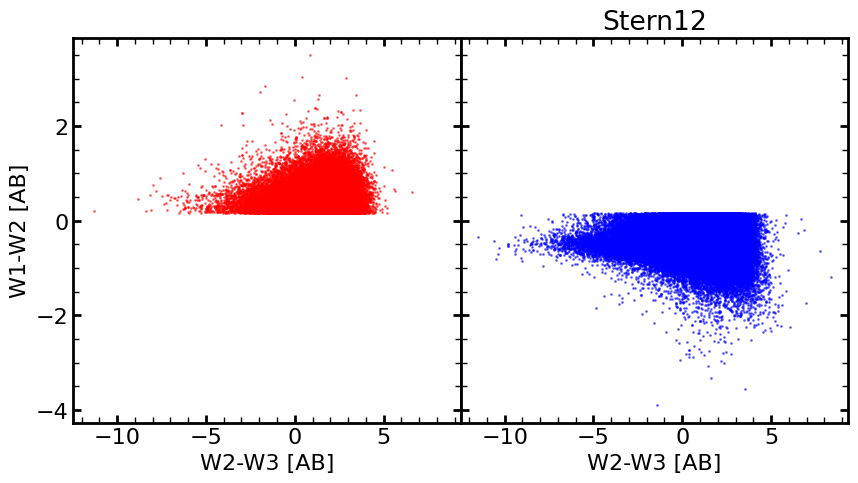

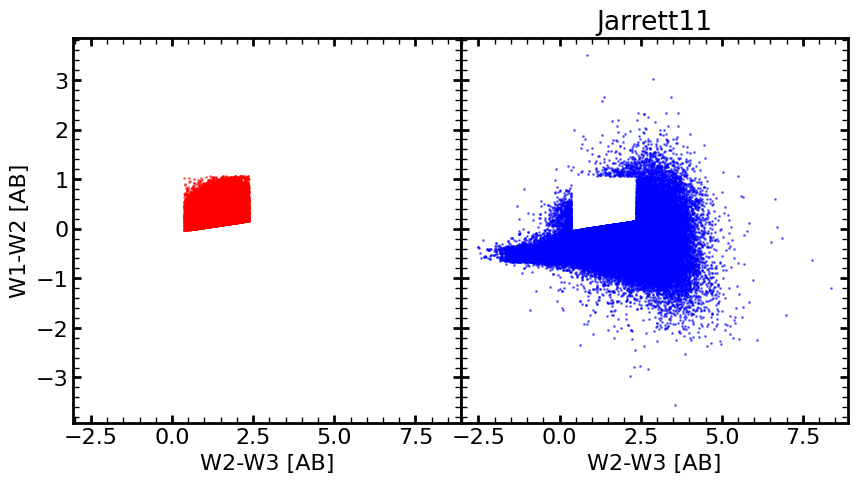

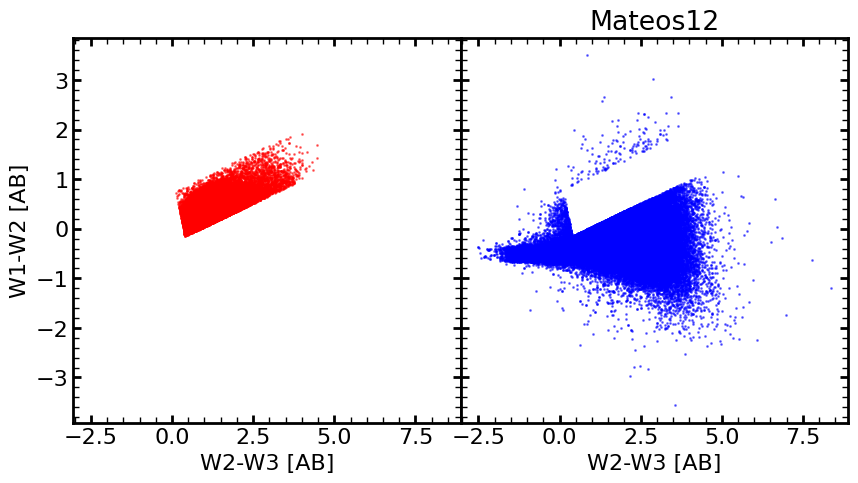

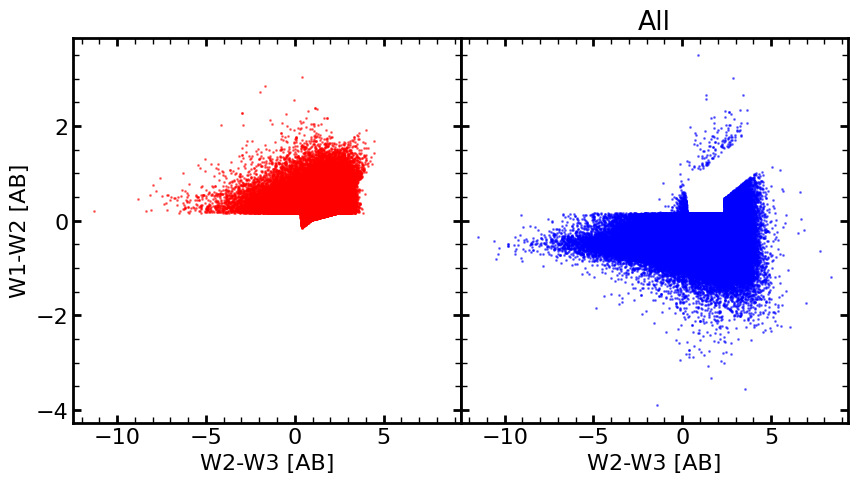

In [15]:
diags = ['Stern12', 'Jarrett11', 'Mateos12', 'All']

for diag in diags:
    
    W1W2_avail, agn_ir, sf_ir = WISE_colors_debug(T, snr=3., mask=None, diag=diag)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.)

    plt.title(diag)
    ax1.scatter(w2w3[agn_ir], w1w2[agn_ir], color='r', s=1, alpha=0.5)
    ax2.scatter(w2w3[sf_ir], w1w2[sf_ir], color='b', s=1, alpha=0.5)

    for ax in [ax1, ax2]:
        ax.set_xlabel('W2-W3 [AB]')
    ax1.set_ylabel('W1-W2 [AB]')